
# AIDI 1002 Final Project — Lightweight TextCNN (HuggingFace `datasets`)

**Paper:** *Light-Weighted CNN for Text Classification* (Yadav, 2020)  
**Date:** 2025-08-13

This notebook is a clean, end-to-end implementation that:
- Loads **AG_NEWS** via **HuggingFace `datasets`** (no `torchtext` required)
- Implements a **Lightweight TextCNN** with **depthwise separable 1D convolutions**
- Trains with a **dual-optimizer schedule** (Adam → SGD on validation plateau)
- Adds a **baseline MLP** for comparison
- Saves artifacts and optionally plots learning curves



## 1) Setup & Device

In [2]:

import os, re, math, random, json, platform, sys
from collections import Counter

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

print("Python:", sys.version)
print("Platform:", platform.platform())
print("PyTorch:", torch.__version__)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Optional: silence HF symlink warning on Windows (harmless otherwise)
os.environ.setdefault("HF_HUB_DISABLE_SYMLINKS_WARNING", "1")


Python: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-11-10.0.26100-SP0
PyTorch: 2.7.1+cpu
Device: cpu


'1'

## 2) Reproducibility

In [3]:

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)


## 3) Dataset — AG_NEWS via HuggingFace `datasets`

In [4]:

# 3.1 Load
ds = load_dataset("ag_news")
train_texts = ds["train"]["text"]
train_labels = ds["train"]["label"]
test_texts  = ds["test"]["text"]
test_labels = ds["test"]["label"]

# 3.2 Tokenizer (basic_english-like)
_word_re = re.compile(r"[A-Za-z0-9']+")
def tokenize(text: str):
    return _word_re.findall(text.lower())

# 3.3 Build vocab from train only
PAD, UNK = "<pad>", "<unk>"
min_freq = 2
counter = Counter()
for t in train_texts:
    counter.update(tokenize(t))

itos = [PAD, UNK] + [tok for tok, freq in counter.items() if freq >= min_freq]
stoi = {tok: i for i, tok in enumerate(itos)}
PAD_ID, UNK_ID = stoi[PAD], stoi[UNK]

class SimpleVocab:
    def __init__(self, stoi, itos, unk_id=1):
        self.stoi = stoi
        self.itos = itos
        self.unk_id = unk_id
    def __len__(self): return len(self.itos)
    def __getitem__(self, tok): return self.stoi.get(tok, self.unk_id)

vocab = SimpleVocab(stoi, itos, unk_id=UNK_ID)

# 3.4 Numericalize
MAX_LEN = 256
def encode_text(text: str):
    ids = [vocab[tok] for tok in tokenize(text)]
    ids = ids[:MAX_LEN]
    if len(ids) < MAX_LEN:
        ids += [PAD_ID] * (MAX_LEN - len(ids))
    return ids

def to_tensors(texts, labels):
    X = [encode_text(t) for t in texts]
    y = list(labels)
    X = torch.tensor(X, dtype=torch.long)
    y = torch.tensor(y, dtype=torch.long)  # already 0..3
    return X, y

X_train_full, y_train_full = to_tensors(train_texts, train_labels)
X_test, y_test = to_tensors(test_texts, test_labels)

# 3.5 Train/Val split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=SEED, stratify=y_train_full
)

print("Vocab size:", len(vocab))
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Label counts (train):", torch.bincount(y_train).tolist())


Vocab size: 46177
Shapes: torch.Size([108000, 256]) torch.Size([12000, 256]) torch.Size([7600, 256])
Label counts (train): [27000, 27000, 27000, 27000]


## 4) Dataloaders

In [5]:

from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 128
use_pin = (DEVICE == "cuda")

train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True,  pin_memory=use_pin)
val_dl   = DataLoader(TensorDataset(X_val,   y_val),   batch_size=BATCH_SIZE, shuffle=False, pin_memory=use_pin)
test_dl  = DataLoader(TensorDataset(X_test,  y_test),  batch_size=BATCH_SIZE, shuffle=False, pin_memory=use_pin)

if not use_pin:
    print("Info: Running on CPU. pin_memory disabled (no impact on correctness).")


Info: Running on CPU. pin_memory disabled (no impact on correctness).


## 5) Models — Lightweight TextCNN + MLP baseline

In [6]:

class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.depthwise = nn.Conv1d(in_channels, in_channels, kernel_size=kernel_size,
                                   groups=in_channels, padding=padding, bias=False)
        self.pointwise = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=True)
        self.bn = nn.BatchNorm1d(out_channels)
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return F.relu(x)

class LightweightTextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_classes=4, kernel_sizes=(3,4,5), channels=64, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_ID)
        self.convs = nn.ModuleList([
            DepthwiseSeparableConv1d(embed_dim, channels, k, padding=k//2)
            for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * channels, num_classes)
        for m in self.modules():
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                if getattr(m, "bias", None) is not None:
                    nn.init.zeros_(m.bias)
    def forward(self, x):
        x = self.embedding(x)
        x = x.transpose(1, 2)
        feats = []
        for conv in self.convs:
            c = conv(x)
            p = F.adaptive_max_pool1d(c, 1).squeeze(-1)
            feats.append(p)
        h = torch.cat(feats, dim=1)
        h = self.dropout(h)
        return self.fc(h)

class MLPText(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden=256, num_classes=4, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_ID)
        self.fc1 = nn.Linear(embed_dim * MAX_LEN, hidden)
        self.bn1 = nn.BatchNorm1d(hidden)
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        x = x.reshape(x.size(0), -1)
        x = self.drop(F.relu(self.bn1(self.fc1(x))))
        return self.fc2(x)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

textcnn = LightweightTextCNN(vocab_size=len(vocab)).to(DEVICE)
mlp     = MLPText(vocab_size=len(vocab)).to(DEVICE)
print("TextCNN params:", count_parameters(textcnn))
print("MLP params:", count_parameters(mlp))


TextCNN params: 5938116
MLP params: 14301060


## 6) Training & Evaluation (Adam → SGD on validation plateau)

In [7]:

def run_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    losses, ys, yhats = [], [], []
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        if is_train:
            optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        if is_train:
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        ys.extend(yb.detach().cpu().numpy().tolist())
        yhats.extend(logits.argmax(1).detach().cpu().numpy().tolist())
    return {
        "loss": float(np.mean(losses)),
        "acc": accuracy_score(ys, yhats),
        "f1m": f1_score(ys, yhats, average="macro")
    }

def train_with_dual_optimizer(model, train_dl, val_dl, epochs=8, lr_adam=1e-3, lr_sgd=5e-3,
                              plateau_patience=2, min_delta=1e-4, momentum=0.9):
    criterion = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=lr_adam)
    using_sgd, best_val, no_improve = False, float("inf"), 0
    history = []
    for ep in range(1, epochs+1):
        tr = run_epoch(model, train_dl, criterion, optimizer=opt)
        va = run_epoch(model, val_dl,   criterion, optimizer=None)
        improved = best_val - va["loss"] > min_delta
        if improved:
            best_val, no_improve = va["loss"], 0
        else:
            no_improve += 1
        if (no_improve >= plateau_patience) and (not using_sgd):
            opt = torch.optim.SGD(model.parameters(), lr=lr_sgd, momentum=momentum)
            using_sgd = True
        history.append({"epoch": ep, "train": tr, "val": va, "optimizer": "SGD" if using_sgd else "Adam"})
        print(f"Epoch {ep:02d} | opt={'SGD' if using_sgd else 'Adam'} | "
              f"train loss {tr['loss']:.4f} acc {tr['acc']:.3f} | "
              f"val loss {va['loss']:.4f} acc {va['acc']:.3f}")
    return model, history


In [8]:
# ==== FAST MODE (smoke test) ====
# 1) Subsample the dataset (keep class balance)
def balanced_subset(X, y, per_class=2000, seed=42):
    import torch, numpy as np, random
    g = torch.Generator().manual_seed(seed)
    idxs = []
    y_np = y.numpy()
    for c in range(4):
        cls_idx = np.where(y_np == c)[0]
        take = min(per_class, len(cls_idx))
        sel = np.random.default_rng(seed+c).choice(cls_idx, size=take, replace=False)
        idxs.extend(sel.tolist())
    random.Random(seed).shuffle(idxs)
    return X[idxs], y[idxs]

X_train_fast, y_train_fast = balanced_subset(X_train, y_train, per_class=2000)  # ~8k rows
X_val_fast,   y_val_fast   = balanced_subset(X_val,   y_val,   per_class=500)   # ~2k rows
X_test_fast,  y_test_fast  = X_test[:2000], y_test[:2000]                        # quick test slice

from torch.utils.data import TensorDataset, DataLoader
BATCH_SIZE_FAST = 256
use_pin = (DEVICE == "cuda")
train_dl_fast = DataLoader(TensorDataset(X_train_fast, y_train_fast), batch_size=BATCH_SIZE_FAST, shuffle=True,  pin_memory=use_pin, num_workers=2)
val_dl_fast   = DataLoader(TensorDataset(X_val_fast,   y_val_fast),   batch_size=BATCH_SIZE_FAST, shuffle=False, pin_memory=use_pin, num_workers=2)
test_dl_fast  = DataLoader(TensorDataset(X_test_fast,  y_test_fast),  batch_size=BATCH_SIZE_FAST, shuffle=False, pin_memory=use_pin, num_workers=2)

# 2) Smaller models (fewer channels/embedding) + fewer epochs
textcnn_fast = LightweightTextCNN(vocab_size=len(vocab), embed_dim=64, kernel_sizes=(3,4,5), channels=32, dropout=0.5).to(DEVICE)
mlp_fast     = MLPText(vocab_size=len(vocab), embed_dim=64, hidden=128, dropout=0.5).to(DEVICE)

print("FAST TextCNN params:", sum(p.numel() for p in textcnn_fast.parameters() if p.requires_grad))
print("FAST MLP params:",     sum(p.numel() for p in mlp_fast.parameters()     if p.requires_grad))

# 3) Train + evaluate (2 epochs)
textcnn_fast, hist_c_fast = train_with_dual_optimizer(textcnn_fast, train_dl_fast, val_dl_fast, epochs=2, lr_adam=1e-3, lr_sgd=5e-3)
from sklearn.metrics import classification_report
crit = nn.CrossEntropyLoss()
tc_test = run_epoch(textcnn_fast, test_dl_fast, crit, optimizer=None)
print("\nFAST TextCNN — Test metrics:", tc_test)

mlp_fast, hist_m_fast = train_with_dual_optimizer(mlp_fast, train_dl_fast, val_dl_fast, epochs=2, lr_adam=1e-3, lr_sgd=5e-3)
mlp_test = run_epoch(mlp_fast, test_dl_fast, crit, optimizer=None)
print("\nFAST MLP — Test metrics:", mlp_test)


FAST TextCNN params: 2962916
FAST MLP params: 5053380
Epoch 01 | opt=Adam | train loss 3.5654 acc 0.251 | val loss 1.4061 acc 0.282
Epoch 02 | opt=Adam | train loss 2.6415 acc 0.281 | val loss 1.3581 acc 0.334

FAST TextCNN — Test metrics: {'loss': 1.3672405183315277, 'acc': 0.326, 'f1m': 0.3180103781344693}
Epoch 01 | opt=Adam | train loss 1.3495 acc 0.369 | val loss 1.2151 acc 0.457
Epoch 02 | opt=Adam | train loss 0.8643 acc 0.709 | val loss 1.1628 acc 0.503

FAST MLP — Test metrics: {'loss': 1.160011425614357, 'acc': 0.497, 'f1m': 0.49460875442982355}


## 7) Train TextCNN, Evaluate, then MLP baseline, Evaluate

In [9]:
print("kernel alive")


kernel alive


In [10]:

# Train TextCNN
textcnn, history_c = train_with_dual_optimizer(textcnn, train_dl, val_dl, epochs=8)

# Evaluate TextCNN
crit = nn.CrossEntropyLoss()
test_metrics_c = run_epoch(textcnn, test_dl, crit, optimizer=None)
print("\nTextCNN — Test metrics:", test_metrics_c)

# Detailed report
y_true, y_pred = [], []
textcnn.eval()
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(DEVICE)
        logits = textcnn(xb)
        y_true.extend(yb.numpy().tolist())
        y_pred.extend(logits.cpu().argmax(1).numpy().tolist())
print("\nTextCNN — Classification Report:\n")
print(classification_report(y_true, y_pred, digits=4))

# Train MLP
mlp, history_m = train_with_dual_optimizer(mlp, train_dl, val_dl, epochs=8)

# Evaluate MLP
mlp_test = run_epoch(mlp, test_dl, nn.CrossEntropyLoss(), optimizer=None)
print("\nMLP — Test metrics:", mlp_test)

y_true_m, y_pred_m = [], []
mlp.eval()
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(DEVICE)
        logits = mlp(xb)
        y_true_m.extend(yb.numpy().tolist())
        y_pred_m.extend(logits.cpu().argmax(1).numpy().tolist())
print("\nMLP — Classification Report:\n")
print(classification_report(y_true_m, y_pred_m, digits=4))

# Results summary
results = {
    "TextCNN_test": test_metrics_c,
    "MLP_test": mlp_test,
    "TextCNN_params": int(sum(p.numel() for p in textcnn.parameters() if p.requires_grad)),
    "MLP_params": int(sum(p.numel() for p in mlp.parameters() if p.requires_grad))
}
print("\nResults summary:\n", json.dumps(results, indent=2))
print(f"\nTextCNN acc={results['TextCNN_test']['acc']:.3f} f1-macro={results['TextCNN_test']['f1m']:.3f} "
      f"({results['TextCNN_params']} params) | "
      f"MLP acc={results['MLP_test']['acc']:.3f} f1-macro={results['MLP_test']['f1m']:.3f} "
      f"({results['MLP_params']} params))")


Epoch 01 | opt=Adam | train loss 1.3091 acc 0.496 | val loss 0.5571 acc 0.815
Epoch 02 | opt=Adam | train loss 0.5524 acc 0.797 | val loss 0.3620 acc 0.882
Epoch 03 | opt=Adam | train loss 0.3792 acc 0.872 | val loss 0.3116 acc 0.896
Epoch 04 | opt=Adam | train loss 0.3054 acc 0.900 | val loss 0.2874 acc 0.904
Epoch 05 | opt=Adam | train loss 0.2566 acc 0.915 | val loss 0.2770 acc 0.908
Epoch 06 | opt=Adam | train loss 0.2208 acc 0.928 | val loss 0.2763 acc 0.909
Epoch 07 | opt=Adam | train loss 0.1917 acc 0.938 | val loss 0.2812 acc 0.909
Epoch 08 | opt=SGD | train loss 0.1658 acc 0.945 | val loss 0.2875 acc 0.908

TextCNN — Test metrics: {'loss': 0.30587584103147186, 'acc': 0.9068421052631579, 'f1m': 0.9067570188808819}

TextCNN — Classification Report:

              precision    recall  f1-score   support

           0     0.9001    0.9105    0.9053      1900
           1     0.9565    0.9616    0.9591      1900
           2     0.8796    0.8726    0.8761      1900
           3    

## 8) Save Artifacts

In [11]:

os.makedirs("artifacts", exist_ok=True)
torch.save(textcnn.state_dict(), "artifacts/lightweight_textcnn.pt")
torch.save(mlp.state_dict(), "artifacts/mlp_text.pt")
with open("artifacts/results.json", "w") as f:
    json.dump(results, f, indent=2)
print("Saved model weights and metrics to ./artifacts")


Saved model weights and metrics to ./artifacts


## 9) Learning Curves

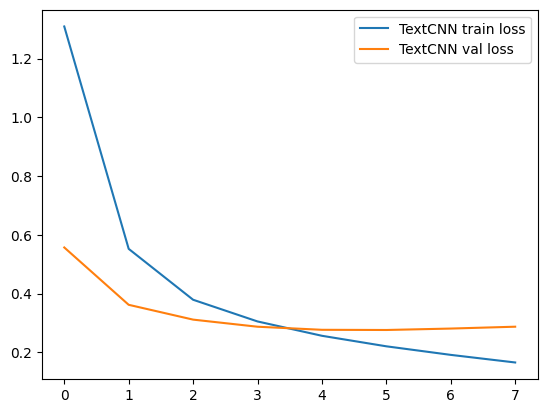

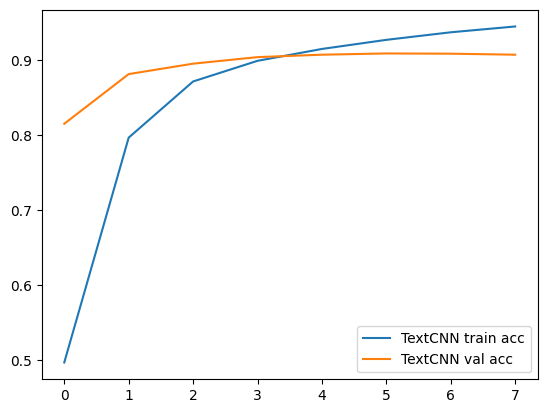

In [12]:

try:
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot([h["train"]["loss"] for h in history_c], label="TextCNN train loss")
    plt.plot([h["val"]["loss"] for h in history_c], label="TextCNN val loss")
    plt.legend(); plt.show()
    plt.figure()
    plt.plot([h["train"]["acc"] for h in history_c], label="TextCNN train acc")
    plt.plot([h["val"]["acc"] for h in history_c], label="TextCNN val acc")
    plt.legend(); plt.show()
except Exception as e:
    print("Skipping plots:", e)
